Ngày	Thời gian	Tốc độ (km/h)
2008-10-23	02:53:10	2.11
2008-10-23	02:53:15	2.04
2008-10-23	02:53:20	1.97
2008-10-23	02:53:25	7.94
2008-10-23	02:53:30	14.96
2008-10-23	02:53:35	16.26
2008-10-23	02:53:40	15.40
2008-10-23	02:53:45	13.81
2008-10-23	02:53:50	15.04
2008-10-23	02:53:55	9.92


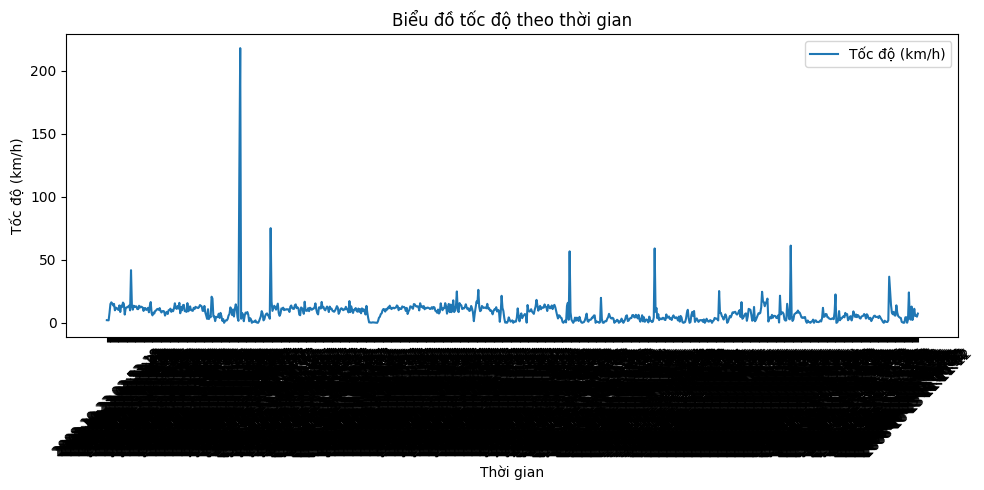

In [8]:
import math
from datetime import datetime

# Hàm Haversine tính khoảng cách giữa hai điểm (vĩ độ, kinh độ)
def haversine(lat1, lon1, lat2, lon2):
    R = 6371  # Bán kính Trái Đất (km)
    lat1, lon1, lat2, lon2 = map(math.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = math.sin(dlat/2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon/2)**2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a))
    return R * c  # Khoảng cách (km)

# Hàm chuyển đổi thời gian HH:MM:SS thành giây
def time_to_seconds(time_str):
    h, m, s = map(int, time_str.split(':'))
    return h * 3600 + m * 60 + s

# Đọc dữ liệu từ file
def read_trajectory(file_path):
    data = []
    with open(file_path, 'r') as f:
        lines = f.readlines()
        # Bỏ qua header (6 dòng đầu)
        for line in lines[6:]:
            parts = line.strip().split(',')
            lat = float(parts[0])
            lon = float(parts[1])
            alt = float(parts[3])
            date = parts[5]
            time = parts[6]
            data.append((lat, lon, alt, date, time))
    return data

# Tính tốc độ
def calculate_speeds(data):
    speeds = []
    for i in range(1, len(data)):
        lat1, lon1, alt1, date1, time1 = data[i-1]
        lat2, lon2, alt2, date2, time2 = data[i]

        # Tính khoảng cách
        distance = haversine(lat1, lon1, lat2, lon2)

        # Tính khoảng thời gian (giây)
        time1_sec = time_to_seconds(time1)
        time2_sec = time_to_seconds(time2)
        time_diff = time2_sec - time1_sec
        if time_diff <= 0:  # Nếu thời gian không tăng, bỏ qua
            continue

        # Tính tốc độ (km/h)
        speed = (distance / time_diff) * 3600  # Chuyển đổi sang km/h
        speeds.append((date2, time2, speed))

    return speeds

# Vẽ biểu đồ tốc độ
def plot_speeds(speeds):
    import matplotlib.pyplot as plt

    times = [f"{date} {time}" for date, time, _ in speeds]
    speed_values = [speed for _, _, speed in speeds]

    plt.figure(figsize=(10, 5))
    plt.plot(times, speed_values, label='Tốc độ (km/h)')
    plt.xlabel('Thời gian')
    plt.ylabel('Tốc độ (km/h)')
    plt.title('Biểu đồ tốc độ theo thời gian')
    plt.xticks(rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()

# Main
file_path = "/content/geolife_date (1).plt"
data = read_trajectory(file_path)
speeds = calculate_speeds(data)

# In một số tốc độ mẫu
print("Ngày\tThời gian\tTốc độ (km/h)")
for date, time, speed in speeds[:10]:  # In 10 giá trị đầu tiên
    print(f"{date}\t{time}\t{speed:.2f}")

# Vẽ biểu đồ
plot_speeds(speeds)

Thời gian bắt đầu	Tốc độ trung bình (km/h)
2008-10-23 02:53:04	10.19
2008-10-23 04:08:07	16.94
2008-10-23 04:23:07	10.33
2008-10-23 09:42:25	5.30
2008-10-23 09:53:06	2.67
2008-10-23 10:08:06	6.14
2008-10-23 10:26:35	4.53
2008-10-23 10:44:31	8.16
2008-10-23 11:08:22	4.60


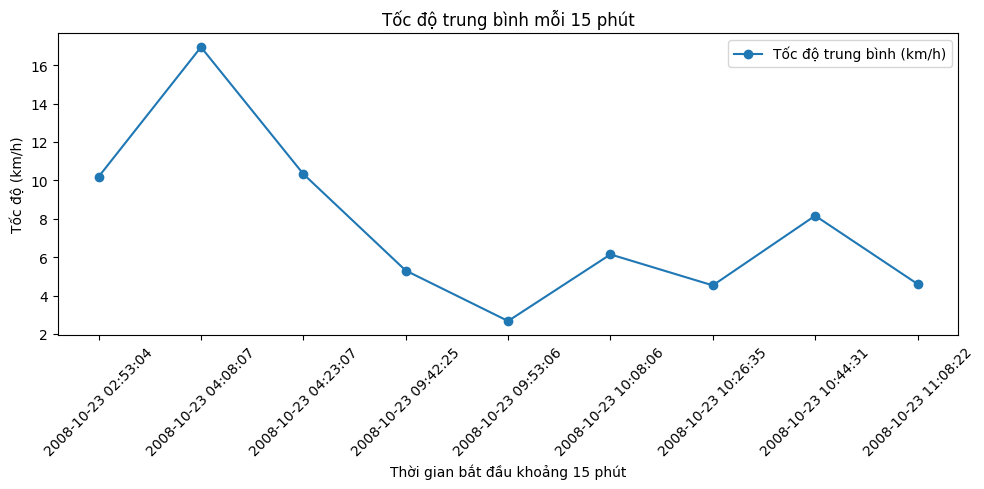

In [9]:
import math
from datetime import datetime
import matplotlib.pyplot as plt

# Hàm Haversine tính khoảng cách giữa hai điểm (vĩ độ, kinh độ)
def haversine(lat1, lon1, lat2, lon2):
    R = 6371  # Bán kính Trái Đất (km)
    lat1, lon1, lat2, lon2 = map(math.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = math.sin(dlat/2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon/2)**2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a))
    return R * c  # Khoảng cách (km)

# Hàm chuyển đổi thời gian thành giây kể từ thời điểm đầu tiên
def time_to_seconds(date_str, time_str, base_datetime):
    dt = datetime.strptime(f"{date_str} {time_str}", "%Y-%m-%d %H:%M:%S")
    return (dt - base_datetime).total_seconds()

# Đọc dữ liệu từ file
def read_trajectory(file_path):
    data = []
    with open(file_path, 'r') as f:
        lines = f.readlines()
        # Bỏ qua header (6 dòng đầu)
        for line in lines[6:]:
            parts = line.strip().split(',')
            lat = float(parts[0])
            lon = float(parts[1])
            alt = float(parts[3])
            date = parts[5]
            time = parts[6]
            data.append((lat, lon, alt, date, time))
    return data

# Nhóm dữ liệu và tính tốc độ trung bình mỗi 15 phút
def calculate_speeds_15min(data):
    if not data:
        return []

    # Lấy thời điểm đầu tiên làm mốc
    base_datetime = datetime.strptime(f"{data[0][3]} {data[0][4]}", "%Y-%m-%d %H:%M:%S")

    # Khoảng thời gian 15 phút (900 giây)
    interval = 900
    speeds = []
    current_group = []
    current_interval_start = 0

    for i in range(len(data)):
        lat, lon, alt, date, time = data[i]
        timestamp = time_to_seconds(date, time, base_datetime)

        # Nếu là điểm đầu tiên hoặc thuộc nhóm 15 phút hiện tại
        if timestamp < current_interval_start + interval:
            current_group.append((lat, lon, alt, date, time, timestamp))
        else:
            # Tính tốc độ trung bình cho nhóm hiện tại
            if len(current_group) > 1:
                total_distance = 0
                for j in range(1, len(current_group)):
                    lat1, lon1 = current_group[j-1][0], current_group[j-1][1]
                    lat2, lon2 = current_group[j][0], current_group[j][1]
                    total_distance += haversine(lat1, lon1, lat2, lon2)

                # Thời gian giữa điểm đầu và cuối của nhóm
                time_diff = current_group[-1][5] - current_group[0][5]
                if time_diff > 0:
                    speed = (total_distance / time_diff) * 3600  # km/h
                    start_time = f"{current_group[0][3]} {current_group[0][4]}"
                    speeds.append((start_time, speed))

            # Bắt đầu nhóm mới
            current_group = [(lat, lon, alt, date, time, timestamp)]
            current_interval_start = (timestamp // interval) * interval

    # Xử lý nhóm cuối cùng
    if len(current_group) > 1:
        total_distance = 0
        for j in range(1, len(current_group)):
            lat1, lon1 = current_group[j-1][0], current_group[j-1][1]
            lat2, lon2 = current_group[j][0], current_group[j][1]
            total_distance += haversine(lat1, lon1, lat2, lon2)

        time_diff = current_group[-1][5] - current_group[0][5]
        if time_diff > 0:
            speed = (total_distance / time_diff) * 3600  # km/h
            start_time = f"{current_group[0][3]} {current_group[0][4]}"
            speeds.append((start_time, speed))

    return speeds

# Vẽ biểu đồ tốc độ
def plot_speeds(speeds):
    times = [start_time for start_time, _ in speeds]
    speed_values = [speed for _, speed in speeds]

    plt.figure(figsize=(10, 5))
    plt.plot(times, speed_values, marker='o', label='Tốc độ trung bình (km/h)')
    plt.xlabel('Thời gian bắt đầu khoảng 15 phút')
    plt.ylabel('Tốc độ (km/h)')
    plt.title('Tốc độ trung bình mỗi 15 phút')
    plt.xticks(rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()

# Main
file_path = "/content/geolife_date (1).plt"
data = read_trajectory(file_path)
speeds = calculate_speeds_15min(data)

# In kết quả
print("Thời gian bắt đầu\tTốc độ trung bình (km/h)")
for start_time, speed in speeds:
    print(f"{start_time}\t{speed:.2f}")

# Vẽ biểu đồ
plot_speeds(speeds)

Thời gian bắt đầu	Tốc độ trung bình (km/h)
2008-10-23 02:53:04	10.19
2008-10-23 04:08:07	16.94
2008-10-23 04:23:07	10.33
2008-10-23 09:42:25	5.30
2008-10-23 09:53:06	2.67
2008-10-23 10:08:06	6.14
2008-10-23 10:26:35	4.53
2008-10-23 10:44:31	8.16
2008-10-23 11:08:22	4.60
Các chu kỳ nổi bật (giờ):
Chu kỳ: 0.75 giờ, Biên độ: 14.54
Chu kỳ: 1.12 giờ, Biên độ: 19.23
Chu kỳ: 2.25 giờ, Biên độ: 68.87


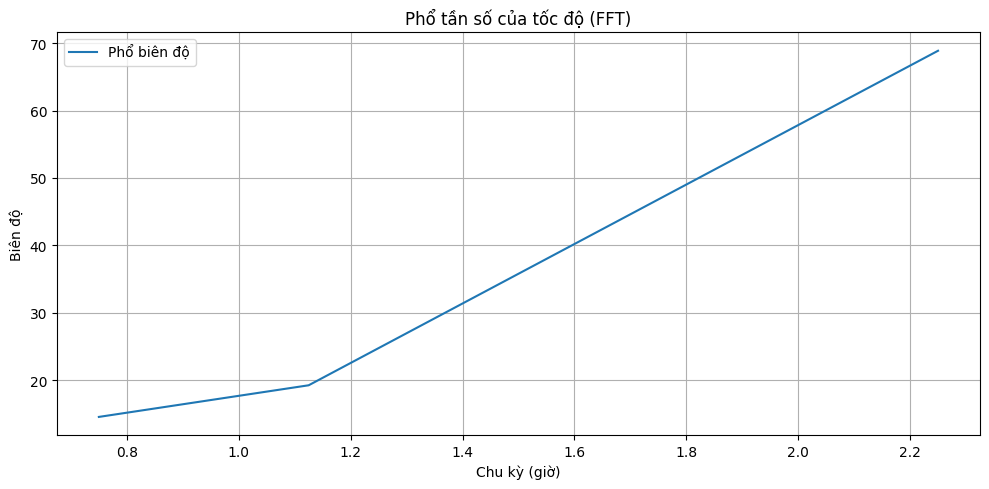

In [10]:
import math
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt

# Hàm Haversine tính khoảng cách giữa hai điểm (vĩ độ, kinh độ)
def haversine(lat1, lon1, lat2, lon2):
    R = 6371  # Bán kính Trái Đất (km)
    lat1, lon1, lat2, lon2 = map(math.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = math.sin(dlat/2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon/2)**2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a))
    return R * c  # Khoảng cách (km)

# Hàm chuyển đổi thời gian thành giây kể từ thời điểm đầu tiên
def time_to_seconds(date_str, time_str, base_datetime):
    dt = datetime.strptime(f"{date_str} {time_str}", "%Y-%m-%d %H:%M:%S")
    return (dt - base_datetime).total_seconds()

# Đọc dữ liệu từ file
def read_trajectory(file_path):
    data = []
    with open(file_path, 'r') as f:
        lines = f.readlines()
        # Bỏ qua header (6 dòng đầu)
        for line in lines[6:]:
            parts = line.strip().split(',')
            lat = float(parts[0])
            lon = float(parts[1])
            alt = float(parts[3])
            date = parts[5]
            time = parts[6]
            data.append((lat, lon, alt, date, time))
    return data

# Nhóm dữ liệu và tính tốc độ trung bình mỗi 15 phút
def calculate_speeds_15min(data):
    if not data:
        return []

    base_datetime = datetime.strptime(f"{data[0][3]} {data[0][4]}", "%Y-%m-%d %H:%M:%S")
    interval = 900  # 15 phút = 900 giây
    speeds = []
    current_group = []
    current_interval_start = 0

    for i in range(len(data)):
        lat, lon, alt, date, time = data[i]
        timestamp = time_to_seconds(date, time, base_datetime)

        if timestamp < current_interval_start + interval:
            current_group.append((lat, lon, alt, date, time, timestamp))
        else:
            if len(current_group) > 1:
                total_distance = 0
                for j in range(1, len(current_group)):
                    lat1, lon1 = current_group[j-1][0], current_group[j-1][1]
                    lat2, lon2 = current_group[j][0], current_group[j][1]
                    total_distance += haversine(lat1, lon1, lat2, lon2)

                time_diff = current_group[-1][5] - current_group[0][5]
                if time_diff > 0:
                    speed = (total_distance / time_diff) * 3600  # km/h
                    start_time = f"{current_group[0][3]} {current_group[0][4]}"
                    speeds.append((start_time, speed, current_group[0][5]))

            current_group = [(lat, lon, alt, date, time, timestamp)]
            current_interval_start = (timestamp // interval) * interval

    # Xử lý nhóm cuối cùng
    if len(current_group) > 1:
        total_distance = 0
        for j in range(1, len(current_group)):
            lat1, lon1 = current_group[j-1][0], current_group[j-1][1]
            lat2, lon2 = current_group[j][0], current_group[j][1]
            total_distance += haversine(lat1, lon1, lat2, lon2)

        time_diff = current_group[-1][5] - current_group[0][5]
        if time_diff > 0:
            speed = (total_distance / time_diff) * 3600  # km/h
            start_time = f"{current_group[0][3]} {current_group[0][4]}"
            speeds.append((start_time, speed, current_group[0][5]))

    return speeds

# Áp dụng FFT và tìm chu kỳ
def apply_fft(speeds):
    # Lấy danh sách tốc độ và thời gian
    speed_values = [speed for _, speed, _ in speeds]
    timestamps = [ts for _, _, ts in speeds]

    # Kiểm tra dữ liệu đủ lớn để áp dụng FFT
    if len(speed_values) < 2:
        print("Không đủ dữ liệu để áp dụng FFT.")
        return

    # Áp dụng FFT
    fft_result = np.fft.fft(speed_values)
    frequencies = np.fft.fftfreq(len(speed_values), d=900)  # Tần số, với khoảng cách mẫu là 900 giây

    # Lấy phổ biên độ (chỉ lấy nửa đầu vì FFT đối xứng)
    amplitudes = np.abs(fft_result)[:len(fft_result)//2]
    frequencies = frequencies[:len(frequencies)//2]

    # Chỉ lấy tần số dương
    positive_freqs = frequencies[frequencies > 0]
    positive_amps = amplitudes[:len(positive_freqs)]

    # Tính chu kỳ (giờ) từ tần số
    periods = [1 / freq / 3600 for freq in positive_freqs if freq != 0]  # Chu kỳ (giờ)

    # Tìm các đỉnh trong phổ biên độ
    peak_indices = np.argsort(positive_amps)[-5:]  # Lấy 5 đỉnh lớn nhất
    peak_periods = [periods[i] for i in peak_indices]
    peak_amplitudes = [positive_amps[i] for i in peak_indices]

    # In các chu kỳ nổi bật
    print("Các chu kỳ nổi bật (giờ):")
    for period, amplitude in zip(peak_periods, peak_amplitudes):
        print(f"Chu kỳ: {period:.2f} giờ, Biên độ: {amplitude:.2f}")

    # Vẽ phổ tần số
    plt.figure(figsize=(10, 5))
    plt.plot(periods, positive_amps, label='Phổ biên độ')
    plt.xlabel('Chu kỳ (giờ)')
    plt.ylabel('Biên độ')
    plt.title('Phổ tần số của tốc độ (FFT)')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

# Main
file_path = "/content/geolife_date (1).plt"
data = read_trajectory(file_path)
speeds = calculate_speeds_15min(data)

# In tốc độ trung bình mỗi 15 phút
print("Thời gian bắt đầu\tTốc độ trung bình (km/h)")
for start_time, speed, _ in speeds:
    print(f"{start_time}\t{speed:.2f}")

# Áp dụng FFT
apply_fft(speeds)

Thời gian bắt đầu	Tốc độ trung bình (km/h)
2008-10-23 02:53:04	10.19
2008-10-23 04:08:07	16.94
2008-10-23 04:23:07	10.33
2008-10-23 09:42:25	5.30
2008-10-23 09:53:06	2.67
2008-10-23 10:08:06	6.14
2008-10-23 10:26:35	4.53
2008-10-23 10:44:31	8.16
2008-10-23 11:08:22	4.60

Các chu kỳ nổi bật (giờ) và phân tích thói quen:
Chu kỳ: 2.25 giờ, Biên độ: 68.87 -> Có thể là thói quen di chuyển định kỳ không cố định.
Chu kỳ: 1.12 giờ, Biên độ: 19.23 -> Có thể là các đợt di chuyển ngắn lặp lại (di chuyển trong thành phố).
Chu kỳ: 0.75 giờ, Biên độ: 14.54 -> Có thể là các đợt di chuyển ngắn lặp lại (di chuyển trong thành phố).


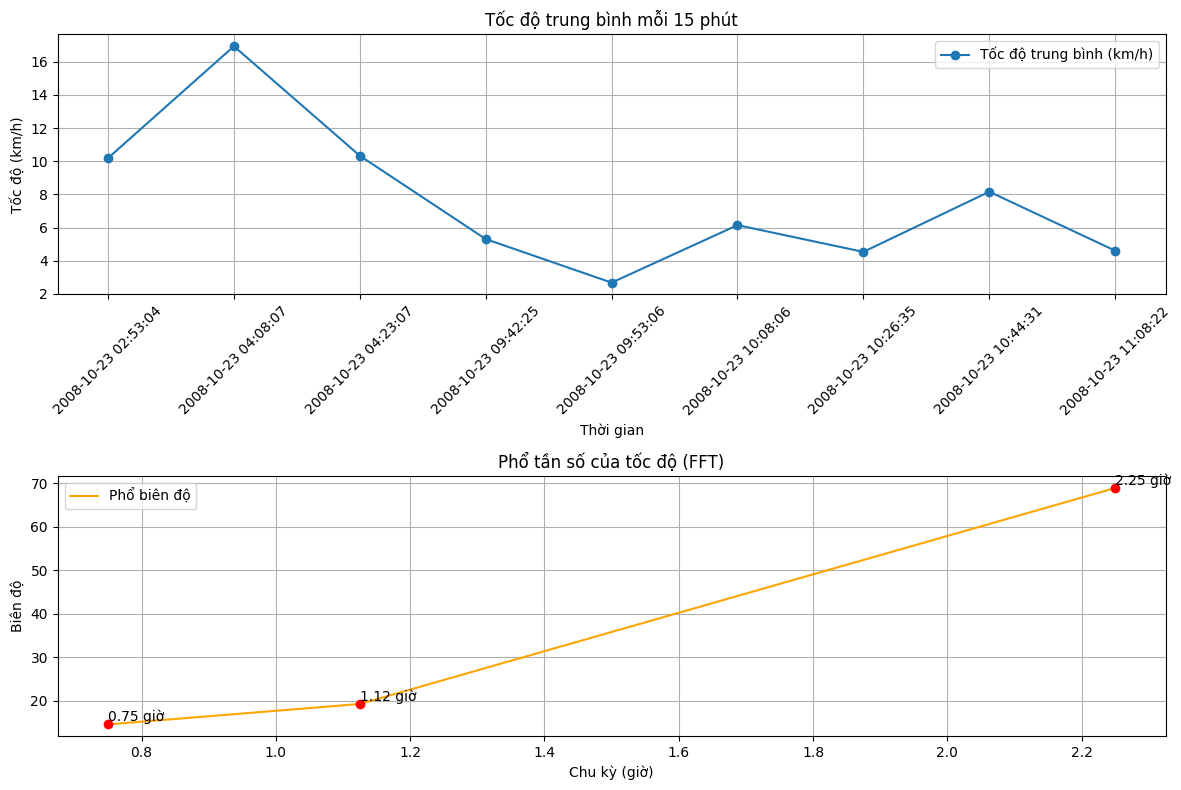

In [11]:
import math
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt

# Hàm Haversine tính khoảng cách giữa hai điểm (vĩ độ, kinh độ)
def haversine(lat1, lon1, lat2, lon2):
    R = 6371  # Bán kính Trái Đất (km)
    lat1, lon1, lat2, lon2 = map(math.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = math.sin(dlat/2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon/2)**2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a))
    return R * c  # Khoảng cách (km)

# Hàm chuyển đổi thời gian thành giây kể từ thời điểm đầu tiên
def time_to_seconds(date_str, time_str, base_datetime):
    dt = datetime.strptime(f"{date_str} {time_str}", "%Y-%m-%d %H:%M:%S")
    return (dt - base_datetime).total_seconds()

# Đọc dữ liệu từ file
def read_trajectory(file_path):
    data = []
    with open(file_path, 'r') as f:
        lines = f.readlines()
        # Bỏ qua header (6 dòng đầu)
        for line in lines[6:]:
            parts = line.strip().split(',')
            lat = float(parts[0])
            lon = float(parts[1])
            alt = float(parts[3])
            date = parts[5]
            time = parts[6]
            data.append((lat, lon, alt, date, time))
    return data

# Nhóm dữ liệu và tính tốc độ trung bình mỗi 15 phút
def calculate_speeds_15min(data):
    if not data:
        return []

    base_datetime = datetime.strptime(f"{data[0][3]} {data[0][4]}", "%Y-%m-%d %H:%M:%S")
    interval = 900  # 15 phút = 900 giây
    speeds = []
    current_group = []
    current_interval_start = 0

    for i in range(len(data)):
        lat, lon, alt, date, time = data[i]
        timestamp = time_to_seconds(date, time, base_datetime)

        if timestamp < current_interval_start + interval:
            current_group.append((lat, lon, alt, date, time, timestamp))
        else:
            if len(current_group) > 1:
                total_distance = 0
                for j in range(1, len(current_group)):
                    lat1, lon1 = current_group[j-1][0], current_group[j-1][1]
                    lat2, lon2 = current_group[j][0], current_group[j][1]
                    total_distance += haversine(lat1, lon1, lat2, lon2)

                time_diff = current_group[-1][5] - current_group[0][5]
                if time_diff > 0:
                    speed = (total_distance / time_diff) * 3600  # km/h
                    start_time = f"{current_group[0][3]} {current_group[0][4]}"
                    speeds.append((start_time, speed, current_group[0][5]))

            current_group = [(lat, lon, alt, date, time, timestamp)]
            current_interval_start = (timestamp // interval) * interval

    # Xử lý nhóm cuối cùng
    if len(current_group) > 1:
        total_distance = 0
        for j in range(1, len(current_group)):
            lat1, lon1 = current_group[j-1][0], current_group[j-1][1]
            lat2, lon2 = current_group[j][0], current_group[j][1]
            total_distance += haversine(lat1, lon1, lat2, lon2)

        time_diff = current_group[-1][5] - current_group[0][5]
        if time_diff > 0:
            speed = (total_distance / time_diff) * 3600  # km/h
            start_time = f"{current_group[0][3]} {current_group[0][4]}"
            speeds.append((start_time, speed, current_group[0][5]))

    return speeds

# Áp dụng FFT và phân tích chu kỳ
def apply_fft_and_analyze(speeds):
    if len(speeds) < 2:
        print("Không đủ dữ liệu để áp dụng FFT.")
        return [], [], []

    # Lấy danh sách tốc độ và thời gian
    speed_values = [speed for _, speed, _ in speeds]
    timestamps = [ts for _, _, ts in speeds]

    # Áp dụng FFT
    fft_result = np.fft.fft(speed_values)
    frequencies = np.fft.fftfreq(len(speed_values), d=900)  # Tần số, khoảng cách mẫu là 900 giây

    # Lấy phổ biên độ (chỉ lấy nửa đầu vì FFT đối xứng)
    amplitudes = np.abs(fft_result)[:len(fft_result)//2]
    frequencies = frequencies[:len(frequencies)//2]

    # Chỉ lấy tần số dương
    positive_freqs = frequencies[frequencies > 0]
    positive_amps = amplitudes[:len(positive_freqs)]

    # Tính chu kỳ (giờ) từ tần số
    periods = [1 / freq / 3600 for freq in positive_freqs if freq != 0]  # Chu kỳ (giờ)

    # Tìm các đỉnh trong phổ biên độ (5 đỉnh lớn nhất)
    peak_indices = np.argsort(positive_amps)[-5:][::-1]  # Sắp xếp giảm dần
    peak_periods = [periods[i] for i in peak_indices]
    peak_amplitudes = [positive_amps[i] for i in peak_indices]

    # Phân tích mẫu thói quen
    print("\nCác chu kỳ nổi bật (giờ) và phân tích thói quen:")
    habits = []
    for period, amplitude in zip(peak_periods, peak_amplitudes):
        habit = f"Chu kỳ: {period:.2f} giờ, Biên độ: {amplitude:.2f}"
        if abs(period - 24) < 1:  # Chu kỳ gần 24 giờ
            habit += " -> Có thể là thói quen di chuyển hàng ngày (chu kỳ 24 giờ)."
        elif abs(period - 12) < 1:  # Chu kỳ gần 12 giờ
            habit += " -> Có thể là thói quen di chuyển hai lần mỗi ngày (sáng/chiều)."
        elif period < 2:  # Chu kỳ ngắn
            habit += " -> Có thể là các đợt di chuyển ngắn lặp lại (di chuyển trong thành phố)."
        else:
            habit += " -> Có thể là thói quen di chuyển định kỳ không cố định."
        habits.append(habit)

    return periods, positive_amps, habits

# Vẽ biểu đồ tốc độ và phổ tần số
def plot_speeds_and_spectrum(speeds, periods, amplitudes, habits):
    # Biểu đồ tốc độ
    plt.figure(figsize=(12, 8))

    plt.subplot(2, 1, 1)
    times = [start_time for start_time, _, _ in speeds]
    speed_values = [speed for _, speed, _ in speeds]
    plt.plot(times, speed_values, marker='o', label='Tốc độ trung bình (km/h)')
    plt.xlabel('Thời gian')
    plt.ylabel('Tốc độ (km/h)')
    plt.title('Tốc độ trung bình mỗi 15 phút')
    plt.xticks(rotation=45)
    plt.legend()
    plt.grid(True)

    # Biểu đồ phổ tần số
    plt.subplot(2, 1, 2)
    plt.plot(periods, amplitudes, label='Phổ biên độ', color='orange')
    plt.xlabel('Chu kỳ (giờ)')
    plt.ylabel('Biên độ')
    plt.title('Phổ tần số của tốc độ (FFT)')
    plt.grid(True)
    plt.legend()

    # Đánh dấu các chu kỳ nổi bật
    peak_indices = np.argsort(amplitudes)[-5:][::-1]
    peak_periods = [periods[i] for i in peak_indices]
    peak_amplitudes = [amplitudes[i] for i in peak_indices]
    for period, amplitude in zip(peak_periods, peak_amplitudes):
        plt.plot(period, amplitude, 'ro')
        plt.text(period, amplitude, f'{period:.2f} giờ', fontsize=10, verticalalignment='bottom')

    plt.tight_layout()
    plt.show()

# Main
file_path = "/content/geolife_date (1).plt"
data = read_trajectory(file_path)
speeds = calculate_speeds_15min(data)

# In tốc độ trung bình mỗi 15 phút
print("Thời gian bắt đầu\tTốc độ trung bình (km/h)")
for start_time, speed, _ in speeds:
    print(f"{start_time}\t{speed:.2f}")

# Áp dụng FFT và phân tích thói quen
periods, amplitudes, habits = apply_fft_and_analyze(speeds)

# In các mẫu thói quen
for habit in habits:
    print(habit)

# Vẽ biểu đồ
plot_speeds_and_spectrum(speeds, periods, amplitudes, habits)

Thời gian bắt đầu	Tốc độ trung bình (km/h)
2008-10-23 02:53:04	10.19
2008-10-23 04:08:07	16.94
2008-10-23 04:23:07	10.33
2008-10-23 09:42:25	5.30
2008-10-23 09:53:06	2.67
2008-10-23 10:08:06	6.14
2008-10-23 10:26:35	4.53
2008-10-23 10:44:31	8.16
2008-10-23 11:08:22	4.60

Diễn giải các tần số chính và thói quen đi lại:
Chu kỳ 1: 2.25 giờ, Biên độ: 68.87
  -> Thói quen: Các chuyến đi ngắn, lặp lại, có thể là di chuyển trong thành phố (đi bộ, xe đạp, hoặc phương tiện công cộng).
     Ví dụ: Di chuyển giữa các điểm trong khu vực nội thành, như đi siêu thị, gặp bạn bè, hoặc công việc ngắn hạn.
Chu kỳ 2: 1.12 giờ, Biên độ: 19.23
  -> Thói quen: Các chuyến đi ngắn, lặp lại, có thể là di chuyển trong thành phố (đi bộ, xe đạp, hoặc phương tiện công cộng).
     Ví dụ: Di chuyển giữa các điểm trong khu vực nội thành, như đi siêu thị, gặp bạn bè, hoặc công việc ngắn hạn.
Chu kỳ 3: 0.75 giờ, Biên độ: 14.54
  -> Thói quen: Các chuyến đi ngắn, lặp lại, có thể là di chuyển trong thành phố (đi bộ, xe đ

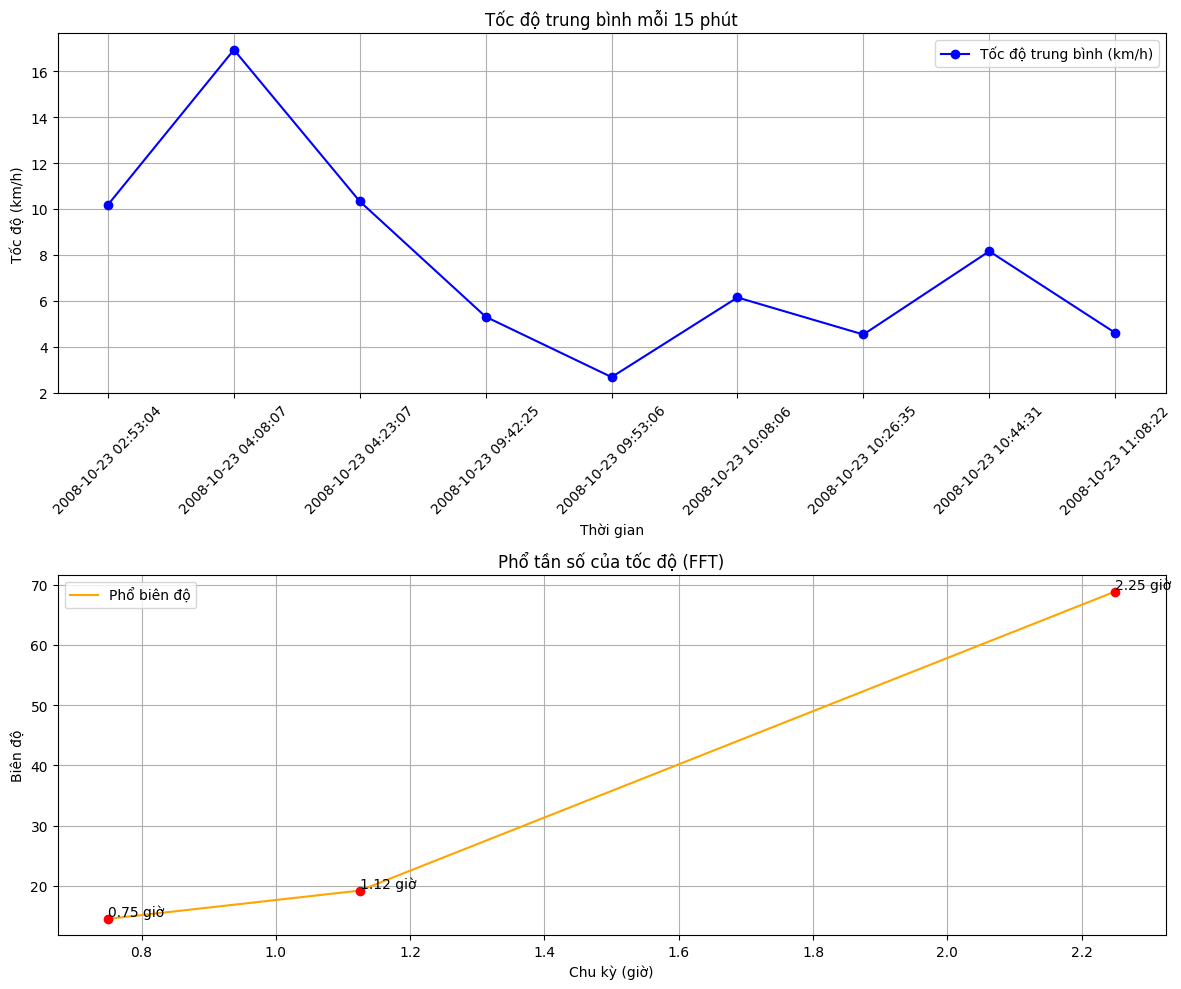

In [12]:
import math
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt

# Hàm Haversine tính khoảng cách giữa hai điểm (vĩ độ, kinh độ)
def haversine(lat1, lon1, lat2, lon2):
    R = 6371  # Bán kính Trái Đất (km)
    lat1, lon1, lat2, lon2 = map(math.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = math.sin(dlat/2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon/2)**2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a))
    return R * c  # Khoảng cách (km)

# Hàm chuyển đổi thời gian thành giây kể từ thời điểm đầu tiên
def time_to_seconds(date_str, time_str, base_datetime):
    dt = datetime.strptime(f"{date_str} {time_str}", "%Y-%m-%d %H:%M:%S")
    return (dt - base_datetime).total_seconds()

# Đọc dữ liệu từ file
def read_trajectory(file_path):
    data = []
    with open(file_path, 'r') as f:
        lines = f.readlines()
        # Bỏ qua header (6 dòng đầu)
        for line in lines[6:]:
            parts = line.strip().split(',')
            lat = float(parts[0])
            lon = float(parts[1])
            alt = float(parts[3])
            date = parts[5]
            time = parts[6]
            data.append((lat, lon, alt, date, time))
    return data

# Nhóm dữ liệu và tính tốc độ trung bình mỗi 15 phút
def calculate_speeds_15min(data):
    if not data:
        return []

    base_datetime = datetime.strptime(f"{data[0][3]} {data[0][4]}", "%Y-%m-%d %H:%M:%S")
    interval = 900  # 15 phút = 900 giây
    speeds = []
    current_group = []
    current_interval_start = 0

    for i in range(len(data)):
        lat, lon, alt, date, time = data[i]
        timestamp = time_to_seconds(date, time, base_datetime)

        if timestamp < current_interval_start + interval:
            current_group.append((lat, lon, alt, date, time, timestamp))
        else:
            if len(current_group) > 1:
                total_distance = 0
                for j in range(1, len(current_group)):
                    lat1, lon1 = current_group[j-1][0], current_group[j-1][1]
                    lat2, lon2 = current_group[j][0], current_group[j][1]
                    total_distance += haversine(lat1, lon1, lat2, lon2)

                time_diff = current_group[-1][5] - current_group[0][5]
                if time_diff > 0:
                    speed = (total_distance / time_diff) * 3600  # km/h
                    start_time = f"{current_group[0][3]} {current_group[0][4]}"
                    speeds.append((start_time, speed, current_group[0][5]))

            current_group = [(lat, lon, alt, date, time, timestamp)]
            current_interval_start = (timestamp // interval) * interval

    # Xử lý nhóm cuối cùng
    if len(current_group) > 1:
        total_distance = 0
        for j in range(1, len(current_group)):
            lat1, lon1 = current_group[j-1][0], current_group[j-1][1]
            lat2, lon2 = current_group[j][0], current_group[j][1]
            total_distance += haversine(lat1, lon1, lat2, lon2)

        time_diff = current_group[-1][5] - current_group[0][5]
        if time_diff > 0:
            speed = (total_distance / time_diff) * 3600  # km/h
            start_time = f"{current_group[0][3]} {current_group[0][4]}"
            speeds.append((start_time, speed, current_group[0][5]))

    return speeds

# Áp dụng FFT và diễn giải thói quen
def apply_fft_and_interpret(speeds):
    if len(speeds) < 2:
        print("Không đủ dữ liệu để áp dụng FFT.")
        return [], [], []

    # Lấy danh sách tốc độ và thời gian
    speed_values = [speed for _, speed, _ in speeds]
    timestamps = [ts for _, _, ts in speeds]

    # Áp dụng FFT
    fft_result = np.fft.fft(speed_values)
    frequencies = np.fft.fftfreq(len(speed_values), d=900)  # Tần số, khoảng cách mẫu là 900 giây

    # Lấy phổ biên độ (chỉ lấy nửa đầu vì FFT đối xứng)
    amplitudes = np.abs(fft_result)[:len(fft_result)//2]
    frequencies = frequencies[:len(frequencies)//2]

    # Chỉ lấy tần số dương
    positive_freqs = frequencies[frequencies > 0]
    positive_amps = amplitudes[:len(positive_freqs)]

    # Tính chu kỳ (giờ) từ tần số
    periods = [1 / freq / 3600 for freq in positive_freqs if freq != 0]  # Chu kỳ (giờ)

    # Tìm các đỉnh trong phổ biên độ (5 đỉnh lớn nhất)
    peak_indices = np.argsort(positive_amps)[-5:][::-1]  # Sắp xếp giảm dần
    peak_periods = [periods[i] for i in peak_indices]
    peak_amplitudes = [positive_amps[i] for i in peak_indices]

    # Diễn giải thói quen đi lại
    interpretations = []
    print("\nDiễn giải các tần số chính và thói quen đi lại:")
    for i, (period, amplitude) in enumerate(zip(peak_periods, peak_amplitudes)):
        interpretation = f"Chu kỳ {i+1}: {period:.2f} giờ, Biên độ: {amplitude:.2f}\n"
        if abs(period - 24) < 2:  # Chu kỳ gần 24 giờ (±2 giờ)
            interpretation += "  -> Thói quen: Di chuyển hàng ngày, có thể là đi làm/về nhà hoặc các hoạt động cố định hàng ngày.\n"
            interpretation += "     Ví dụ: Người dùng có thể đi từ nhà đến nơi làm việc vào buổi sáng và trở về vào buổi tối."
        elif abs(period - 12) < 1:  # Chu kỳ gần 12 giờ
            interpretation += "  -> Thói quen: Di chuyển hai lần mỗi ngày, có thể là các chuyến đi sáng/chiều (như đi làm và đi ăn trưa).\n"
            interpretation += "     Ví dụ: Di chuyển từ nhà đến văn phòng vào sáng sớm và từ văn phòng đến nhà hàng hoặc về nhà vào buổi trưa."
        elif abs(period - 8) < 1:  # Chu kỳ gần 8 giờ
            interpretation += "  -> Thói quen: Di chuyển ba lần mỗi ngày, có thể liên quan đến lịch trình làm việc hoặc học tập.\n"
            interpretation += "     Ví dụ: Di chuyển giữa nhà, trường học/văn phòng, và các địa điểm khác (như phòng gym)."
        elif period < 4:  # Chu kỳ ngắn (<4 giờ)
            interpretation += "  -> Thói quen: Các chuyến đi ngắn, lặp lại, có thể là di chuyển trong thành phố (đi bộ, xe đạp, hoặc phương tiện công cộng).\n"
            interpretation += "     Ví dụ: Di chuyển giữa các điểm trong khu vực nội thành, như đi siêu thị, gặp bạn bè, hoặc công việc ngắn hạn."
        else:  # Các chu kỳ khác
            interpretation += "  -> Thói quen: Di chuyển định kỳ không cố định, có thể liên quan đến các hoạt động đặc biệt (như công tác, du lịch).\n"
            interpretation += "     Ví dụ: Các chuyến đi không thường xuyên hoặc các hoạt động cuối tuần."
        interpretations.append(interpretation)

    return periods, positive_amps, interpretations

# Vẽ biểu đồ tốc độ và phổ tần số
def plot_speeds_and_spectrum(speeds, periods, amplitudes, interpretations):
    plt.figure(figsize=(12, 10))

    # Biểu đồ tốc độ
    plt.subplot(2, 1, 1)
    times = [start_time for start_time, _, _ in speeds]
    speed_values = [speed for _, speed, _ in speeds]
    plt.plot(times, speed_values, marker='o', label='Tốc độ trung bình (km/h)', color='blue')
    plt.xlabel('Thời gian')
    plt.ylabel('Tốc độ (km/h)')
    plt.title('Tốc độ trung bình mỗi 15 phút')
    plt.xticks(rotation=45)
    plt.legend()
    plt.grid(True)

    # Biểu đồ phổ tần số
    plt.subplot(2, 1, 2)
    plt.plot(periods, amplitudes, label='Phổ biên độ', color='orange')
    plt.xlabel('Chu kỳ (giờ)')
    plt.ylabel('Biên độ')
    plt.title('Phổ tần số của tốc độ (FFT)')
    plt.grid(True)
    plt.legend()

    # Đánh dấu các chu kỳ nổi bật
    peak_indices = np.argsort(amplitudes)[-5:][::-1]
    peak_periods = [periods[i] for i in peak_indices]
    peak_amplitudes = [amplitudes[i] for i in peak_indices]
    for period, amplitude in zip(peak_periods, peak_amplitudes):
        plt.plot(period, amplitude, 'ro')
        plt.text(period, amplitude, f'{period:.2f} giờ', fontsize=10, verticalalignment='bottom')

    plt.tight_layout()
    plt.show()

# Main
file_path = "/content/geolife_date (1).plt"
data = read_trajectory(file_path)
speeds = calculate_speeds_15min(data)

# In tốc độ trung bình mỗi 15 phút
print("Thời gian bắt đầu\tTốc độ trung bình (km/h)")
for start_time, speed, _ in speeds:
    print(f"{start_time}\t{speed:.2f}")

# Áp dụng FFT và diễn giải
periods, amplitudes, interpretations = apply_fft_and_interpret(speeds)

# In diễn giải
for interpretation in interpretations:
    print(interpretation)

# Vẽ biểu đồ
plot_speeds_and_spectrum(speeds, periods, amplitudes, interpretations)